In [1]:
import numpy as np
import sympy as sp
import networkx as nx
import matplotlib as plt
from collections import Counter
import itertools
import tqdm
import time
import datetime
import functools
import matplotlib.pyplot
import numba
# import pydot
# from networkx.drawing.nx_pydot import write_dot
from solitaire import Solitaire
%matplotlib inline

In [2]:
%load_ext snakeviz

In [2]:
def plot_game(game):    
    occurences = Counter(game.node[g]['holes'] for g in game.nodes())
    
    max_holes = occurences.most_common()[0][0]
    max_board_holes = occurences.most_common()[0][1]

    hole_count = [0]*max_board_holes
    game_pos = {}
    for key in game.node:
        holes = game.node[key]['holes']
        game_pos[key] = (hole_count[holes-1], holes)
        hole_count[holes-1] += 1
    
  
    nx.draw(game, pos=game_pos)
        
    
    

In [4]:
# game = Solitaire.cross()
# game = Solitaire.triangle()
game = Solitaire.rhombus()

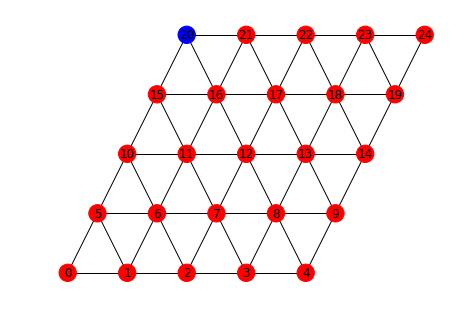

In [5]:
game.draw_board()

In [7]:
def occupancy_list(g):
    return list(map(lambda key: g.node[key]['peg'], sorted(g.node.keys())))

peg_list = occupancy_list(G)

# @numba.njit
def int_repr(pegs):
    x = np.uint64(0)
    for n, peg in enumerate(pegs):
        if peg:
            x += np.power(np.uint64(2), np.uint64(n) )
    return x 

# @numba.njit
def binary_repr(x, width):
    bins = np.binary_repr(x, width=width)[::-1]
    return list(map(bool, map(int, bins)))
    
def binary_to_graph(bins, g):
    for x, y in zip(bins, g.node):
        g.node[y]['peg'] = x
    return g

In [8]:
def jumper(peg_list, neighbor_jumper_pairs):
    for n0, peg in enumerate(peg_list):
        if not peg:
            for n1, n2 in neighbor_jumper_pairs[n0]:
                if peg_list[n1] and peg_list[n2]:
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
                    yield peg_list
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]

new_graphs = jumper(peg_list, neighbor_jumper_pairs)

In [12]:
# %%snakeviz
t0 = time.time()


current = {int_repr(occupancy_list(G))}
G_copy = G.copy()

peg_list = occupancy_list(G)

np.save('{}_{}'.format(name, 1), np.array([int_repr(peg_list)]))
for holes in tqdm.tnrange(1, max_steps, desc='holes: '):
    futures = set()
    for current_int in tqdm.tqdm_notebook(current, desc='{:2}/{:2}'.format(holes+1, max_steps)):
        current_pegs = binary_repr(current_int, total_holes) 
        for new_graph in jumper(current_pegs, neighbor_jumper_pairs):
            new_graph = int_repr(new_graph)
            if new_graph not in futures:
                futures.add(new_graph)
    
    np.save('{}_{}'.format(name, holes+1), np.array(list(futures)))
    current = futures

print('Elapsed time: ', datetime.timedelta(seconds=time.time()-t0))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/viktor/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/viktor/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/viktor/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

KeyboardInterrupt: 

In [16]:
def reverse_jumper(peg_list, neighbor_jumper_pairs):
    for n0, peg in enumerate(peg_list):
        if peg:
            for n1, n2 in neighbor_jumper_pairs[n0]:
                if (not peg_list[n1]) and (not peg_list[n2]):
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
                    yield peg_list
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
            

# Reverse Search Solution

## Finals boards

In [17]:
solution = nx.DiGraph()
boards =  np.load('{}_{}.npy'.format(name, max_steps))

for board_int in boards:
    board_bin = binary_repr(board_int, total_holes)
    board = binary_to_graph(board_bin, G)
    solution.add_node(board_int, board=board)

final_boards = boards
print(boards)

[4194304     128       2  524288    1024    8192   65536      16]


## Search backwards

In [19]:
# %%snakeviz
t0 = time.time()
prev_boards = final_boards
for holes in tqdm.tnrange(max_steps-1, 0, -1, desc='holes:'):
    boards = np.load('{}_{}.npy'.format(name, holes))
    temp = set()
    for prev_board in tqdm.tqdm_notebook(prev_boards, desc='{}/{}  {}'.format(holes, max_steps, len(prev_boards))):
        for next_board in reverse_jumper(binary_repr(prev_board, total_holes), neighbor_jumper_pairs):
            next_int = int_repr(next_board)
            if next_int in boards:
                if next_int not in temp:
                    temp.add(next_int)
                    solution.add_node(next_int, board=binary_to_graph(next_board, G))
                solution.add_edge(next_int, prev_board)
    prev_boards = temp
test = solution.adjacency()
print('Elapsed time: {}'.format(datetime.timedelta(seconds=time.time()-t0)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/viktor/anaconda3/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/viktor/anaconda3/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/viktor/anaconda3/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



KeyboardInterrupt: 

In [200]:
next(test)

(31407, {29247: {}, 31461: {}})

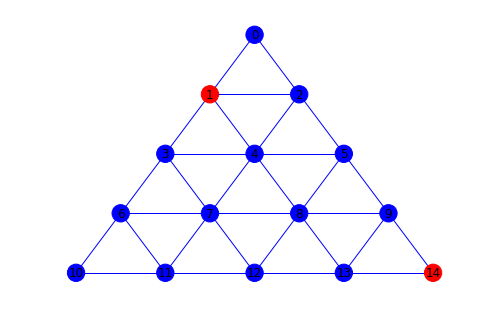

In [173]:
plot_graph_with_labels(binary_to_graph(binary_repr(16386, total_holes), G), pos)

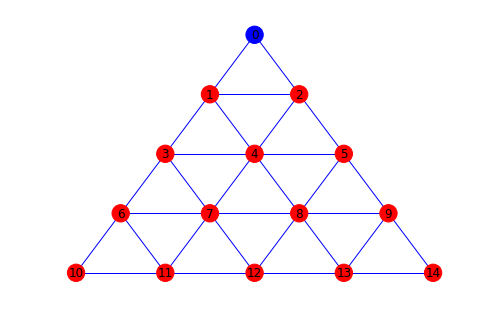

In [210]:
initial_int = np.load('{}_{}.npy'.format(name, holes))[0]
initial_bin = binary_repr(initial_int, total_holes)
initial_graph = binary_to_graph(initial_bin, G)
plot_graph_with_labels(initial_graph, pos)